# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probabilities generated by such a model to assess how predictable the style of a sentence is. For instance, in the following English language sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities - since the comparison to television makes the presence of the word less predictable. In short, BERT is better at predicting boilerplate than original writing. 

<br>
<br>

I would like to extend this beyond the scope of a single word and onto the scale of a complete sentence, i.e. evaluating a sentence's predictability. This approach makes sense because the way BERT computes probability would reflect a couple of things typically associated with literary originality: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and literary or poetic language (we might say, in structuralist terms, that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by the "poetic function" of language)

This predictability score could then be used as a metric for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature, for instance if we were to compare it against signs of literary recognition (literary prizes, publication in prestigious or non-prestigious publishing houses...), enabling us to evaluate how much a certain literary culture values conformity over creativity (or vice-versa) at a certain point in time.

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, known as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in tasks such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in a particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right. They do not use the whole sentence as context to predict a single word. Some models combine left-to-right models with right-to-left models, but the process is still different from BERT since the probability is computed from the knowledge of what comes before only and what comes after only, not on the entire context.
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct (or intentionally incorrect). This allows us to be more selective in the categories of word we want to evaluate, skipping pronouns or particles (*still requires further investigation*).

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word within a sentence. 

<a href=' https://arxiv.org/pdf/1906.00363.pdf'>Wang et al (2019)</a> averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by sequential language models. 

<a href='https://assets.amazon.science/cc/54/980cb7d74f93849b49b9d5c42466/masked-language-model-scoring.pdf'>Salazar et al (2020)</a> develop a measure of "pseudo-perplexity" to rank sentences with BERT by used log probabilities. This pseudo-perplexity is defined as: $exp(-1/n\sum_{i=1}^{n}log(p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n})))) $. This is the measure we'll rely on. 

Point 2 is tied to language specific issues, adressed in the "Language specifics" section below.

### Issues with the metric

Perplexity score is traditionally used to rank different versions of the *same sentence* when generating text with a language model. Because the variation between such sentences is limited, it seems that the behavior of the perplexity score across widely different sentences (as we are doing here) is still unexplored. 
Differences in perplexity scores are minimal. Probabilities for every word tend to be low, but the absolute value hardly matters, the differential from the next word's probability is important. The difference in the mean values of the sentences of our corpus will likewise be tiny, statistical significance may be achieved because of large sample size, but whether that indeed represents an actual effect is less certain.

### Language specifics

Working with Korean and with literary texts, the above formula seems to present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. Because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>). (Note that this extra step would not be needed if we did not want to exclude certain grammatical categories: we could simply use the mean of the probabilities of the differents parts of a word that was split as the probability of that word).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

30000 Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 
5. Collections of poetry

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years). All content used came from the years 1967 - 2018.

<hr>

## Code

In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("../jobert")
model = AutoModelWithLMHead.from_pretrained("../jobert")

I1002 10:20:27.114627 10308 file_utils.py:39] PyTorch version 1.6.0 available.
I1002 10:20:33.041808 10308 file_utils.py:55] TensorFlow version 2.2.0 available.
I1002 10:20:35.426444 10308 configuration_utils.py:262] loading configuration file ../jobert\config.json
I1002 10:20:35.428440 10308 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I1002 10:20:35.429437 10308 tokenization_utils_base.py:1167] Model name '../jobert' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-l

In [2]:
from konlpy.tag import Komoran
komoran = Komoran()

In [3]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_word_by_word_proba(sequence, tokenized=False):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'NR', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    if not tokenized:
        tokenized_sequence = komoran.pos(sequence)
    else:
        tokenized_sequence = sequence
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def compute_word_by_word_proba_no_filter(sequence, tokenized=False):
    global tokenizer
    global komoran
    word_dict = {}
    if not tokenized:
        tokenized_sequence = komoran.pos(sequence)
    else:
        tokenized_sequence = sequence
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        masked_sequence = sequence.replace(token, tokenizer.mask_token)
        word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def compute_sentence_pseudo_perplexity_no_filter(sentence, tokenized=False):
    return np.exp(-1*(np.mean([np.log(p) for p in list(compute_word_by_word_proba_no_filter(sentence, tokenized).values())])))

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence, tokenized=False):
    return geometric_mean(list(compute_word_by_word_proba(sentence, tokenized).values()))

def compute_sentence_pseudo_log_likelihood(sentence, tokenized=False):
    return abs(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())]))

def compute_sentence_pseudo_perplexity(sentence, tokenized=False):
    return np.exp(-1*(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())])))

In [326]:
seq = '젊은이들은 조심히 김진수의 낯빛을 살피며 한숨을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq))
seq2 = '젊은이들은 조심히 김진수의 낯빛을 살피며 음식을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq2))
seq3 = '젊은이들은 조심히 김진수의 낯빛을 살피며 도서관을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq3))

1.1840551468688112
1.1708098991240796
1.1493132982953256


### With a pre-processed corpus

In [4]:
import pickle
with open('processed_corpus.pkl', 'rb') as fp:
    processed_corpus = pickle.load(fp)

In [50]:
from tqdm import tqdm
final_results = {}
for corpus in processed_corpus.keys():
    scores = []
    print(corpus)
    for tokenized_sentence in tqdm(processed_corpus[corpus]['tokens'][:10000]):
        try:
            score = compute_sentence_pseudo_perplexity(tokenized_sentence, tokenized=True)
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    final_results[corpus] = scores

Korean Central News Agency


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9136/10000 [4:38:55<22:23,  1.55s/it]W1002 22:07:14.623958 10308 tokenization_utils_base.py:2081] Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


Error: 지승하는 발목의 아픔을 참으면서도 박영진의 말을 신중하게 새겨듣고 있었다.
index out of range in self


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [4:59:33<00:00,  1.16s/it]


Poetry


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:41<00:00,  7.28it/s]


Regular Novels


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:22:23<00:00,  2.89it/s]


Prestigious Novels


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:24:37<00:00,  2.36it/s]


Canonical Novels


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:23:21<00:00,  2.78it/s]


### With a non pre-processed corpus

In [217]:
import os
from tqdm import tqdm


sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(tqdm(sentences[:50])):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    final_results[file] = scores
    
#with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
#    pickle.dump(final_results, fp)


Canonical Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<00:48,  1.00it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:01<00:38,  1.24it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:31,  1.49it/s]

  8%|█████████████▌                                                                                                                                                   

Central News Agency.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<01:04,  1.31s/it]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:04<01:23,  1.75s/it]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:04<01:08,  1.45s/it]

  8%|█████████████▌                                                                                                                                                   

Poetry.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:14,  3.39it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:13,  3.61it/s]

  8%|█████████████▌                                                                                                                                                            | 4/50 [00:00<00:10,  4.56it/s]

 12%|████████████████████▍                                                                                                                                            

Prestigious Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:12,  3.96it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:16,  2.87it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:14,  3.19it/s]

  8%|█████████████▌                                                                                                                                                   

Regular Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:23,  2.07it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:20,  2.32it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:20,  2.24it/s]

  8%|█████████████▌                                                                                                                                                   

### Outputing results

In [57]:
import pandas as pd
df = pd.DataFrame(final_results)
df

Korean Central News Agency      Poetry  Regular Novels  \
0                      440.68560   125.98328        76.17945   
1                      124.92213  1466.58011       202.90917   
2                       28.87339 19217.13899        93.29541   
3                        4.81182   366.10171       179.57471   
4                       10.56561   102.58855       260.79944   
...                          ...         ...             ...   
9995                    14.84482    17.91680        49.58129   
9996                    14.05801   334.03903        52.54252   
9997                   273.46265    13.25513       243.94831   
9998                     5.11554   420.03820       893.06522   
9999                    27.99878   133.95307      3664.67629   

      Prestigious Novels  Canonical Novels  
0              211.60474         144.08160  
1               44.55124         339.04659  
2              859.41408         390.11261  
3             1383.60689         357.51714  
4              598.79905          17.36578  
...                  ...               ...  
9995           215.42708         191.93328  
9996           124.08398          90.34196  
9997            64.99759         155.06483  
9998           136.98851         290.36099  
9999            48.68487         267.72966  

[10000 rows x 5 columns]

[None, None, None, None, None]

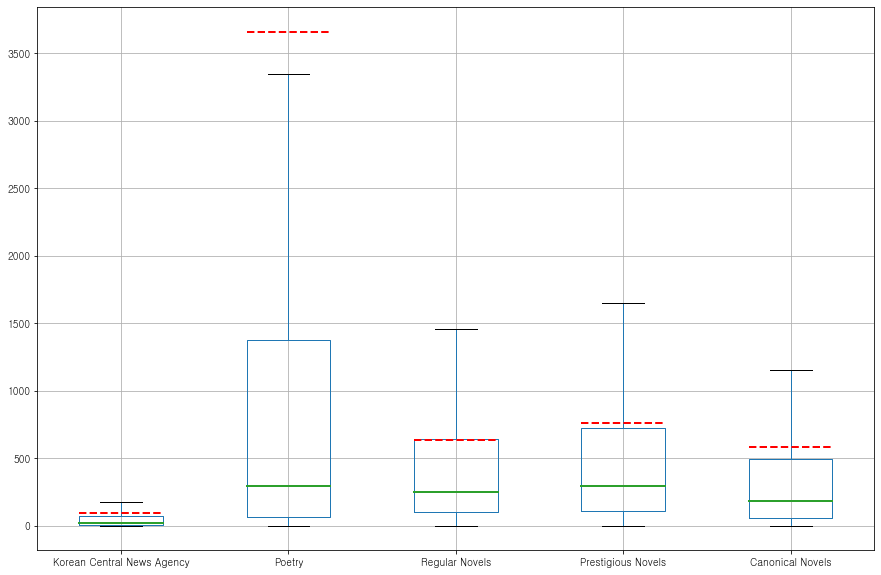

In [56]:
%matplotlib inline
bp = df.boxplot(figsize = (15, 10), showfliers=False, showmeans=True, meanline=True, return_type='dict')
[item.set_linewidth(2) for item in bp['medians']]
[item.set_linewidth(2) for item in bp['means']]
[item.set_color('red') for item in bp['means']]

In [116]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df.describe()

Korean Central News Agency    Poetry  Regular Novels  \
count                     10000.0   10000.0         10000.0   
mean                         98.0    3661.4           638.5   
std                         354.1   29200.8          1877.7   
min                           1.1       1.0             1.2   
25%                           8.5      62.8           100.4   
50%                          24.2     298.8           252.9   
75%                          75.8    1375.8           643.2   
max                       13164.3 1808681.5        122895.7   

       Prestigious Novels  Canonical Novels  
count             10000.0           10000.0  
mean                764.9             583.7  
std                2363.0            2064.0  
min                   1.9               1.2  
25%                 106.9              61.5  
50%                 292.6             182.8  
75%                 723.9             498.7  
max              126058.1           98007.0

In [59]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Poetry
Ttest_indResult(statistic=-12.202409015091877, pvalue=3.990677910285144e-34)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=-28.288460810102624, pvalue=1.1905671599974977e-172)
Korean Central News Agency : Prestigious Novels
Ttest_indResult(statistic=-27.910794040491613, pvalue=3.2745172564801103e-168)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=-23.196552378909587, pvalue=1.750495016492602e-117)
Poetry : Regular Novels
Ttest_indResult(statistic=10.33092141348308, pvalue=5.900937362816559e-25)
Poetry : Prestigious Novels
Ttest_indResult(statistic=9.887121838108815, pvalue=5.346086763900401e-23)
Poetry : Canonical Novels
Ttest_indResult(statistic=10.513540124257931, pvalue=8.736991282768975e-26)
Regular Novels : Prestigious Novels
Ttest_indResult(statistic=-4.187425058084331, pvalue=2.833447490027833e-05)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=1.9623655205656974, pvalue=0.04973378

In [115]:
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    stat, p, med, tbl = stats.median_test(df[a],df[b])
    print(p)

Korean Central News Agency : Poetry
0.0
Korean Central News Agency : Regular Novels
0.0
Korean Central News Agency : Prestigious Novels
0.0
Korean Central News Agency : Canonical Novels
0.0
Poetry : Regular Novels
9.232882535985807e-07
Poetry : Prestigious Novels
0.5062549491139177
Poetry : Canonical Novels
3.065386835854035e-49
Regular Novels : Prestigious Novels
5.1981310351569785e-09
Regular Novels : Canonical Novels
1.020606852529651e-36
Prestigious Novels : Canonical Novels
4.8491017471046016e-70


## Most cliche sentences

In [61]:
import numpy as np

def get_top_index(a, n):
    return np.argsort(a)[:n]

def get_flop_index(a, n):
    return np.argsort(a)[::-1][:n]

In [124]:
for corpus in list(final_results.keys()):
    print('TOP 10 Cliches for:', corpus)
    for index in get_top_index(final_results[corpus], 11):
        print(processed_corpus[corpus]['raw'][index])

TOP 10 Cliches for: Korean Central News Agency
위대한 령도자 김정일동지께서는 다음과 같이 지적하시였다.
위대한 령도자 김정일동지께서는 다음과 같이 지적하시였다.
위대한 령도자 김정일동지께서는 다음과 같이 지적하시였다.
그 승리를 안아오도록 이끌어주신 분은 위대한 령도자 김정일동지이시다.
나는 이 기회에 우리 두 나라사이의 친선협조관계가 앞으로도 계속 좋게 발전하리라는 확신을 표명합니다.
이 기회에 나는 당신의 사업에서 보다 큰 성과가 있을것을 축원하면서 우리 두 나라사이의 친선협조관계가 앞으로 더욱 강화발전되리라는 확신을 표명합니다.
참가자들은 위대한 수령 김일성동지의 동상에 꽃바구니와 꽃다발들을 진정하고 어버이수령님의 동상을 우러러 삼가 인사를 드리였다.
이 나라주재 우리 나라 대사와 대사관성원들이 여기에 초대되였다.
이 나라 주재 우리 나라 대사와 대사관 성원들이 여기에 초대되였다.
개인필명의 글은 다음과 같이 지적하였다.
위대한 령도자 김정일장군님께서는 다음과 같이 지적하시였다.
TOP 10 Cliches for: Poetry
해마다 해마다
해마다 해마다
위대한 수령 김일성동지의
아, 위대한 령도자 김정일동지
위대한 수령 김일성동지!
이 땅에 락원을 일떠세우시며
그이께서 걸으시는 길에
내 조국의 래일을
해빛같은 미소를 지으시며
경애하는 원수님
그이의 고향집을 찾으시는
TOP 10 Cliches for: Regular Novels
그런데 이 모든것과 헤여져야 하다
그가 언제면 돌아 오겠는가, 돌아 올수 있기나 하겠는가.
느니 안됐다느니 하는 소리까지 했다.
이 일을 누가 맡아할수 있는가.
이렇게 한것이 한두개가 아닐지도 모른다.
(어떻게 하면 한마음 한뜻으로 묶어세울수 있을가?)
그럼 나는 어떻게 해야 하는가?.
우린 장군님께 기쁨을 드리지 못한 사람들입니다.
그는 저도 모르게 소리없이 웃었다.
전쟁의 불을 지른 장본인은 세계제패를 노리는 미제침략자들이다.
누만 하는 소리를 그렇게도 듣고싶은가.
TOP 10 Cliche

In [128]:
for corpus in list(final_results.keys()):
    print('TOP 10 Less Cliches for:', corpus)
    for index in get_flop_index(final_results[corpus], 10):
        print(processed_corpus[corpus]['raw'][index])

TOP 10 Less Cliches for: Korean Central News Agency
가자 조국에로,나무껍질을 우려먹으면서라도 가자,희생도 있을수 있고 우여곡절도 있을수 있다,
리철호동포의 고향은 경상북도 경산시 룡성면 도덕리이다.
법안 에 영주외국인은 외국인등록원표의 국적기재가 국명으로 되여있는자에 한한다.
명색만 갖추고 공회전만 하는 회담은 무익하며 불필요하다.
또한 남조선 삼성그룹 윤종룡부회장일행이 주석단에 나왔다.
이것은 시국의 요청이고 민족사의 령이다.
그런데 무엇때문에 명절을 함께 쇠자는 순수한 성의와 호의를 뚱딴지같이 정치성 이니, 통일전선전략 이니 하고 이러쿵저러쿵 하는가 하는것이다.
우리는 사상도 견실하고 총대도 굳건하다.
이날 부인은 평양시녀성들과 좌담회를 가지였다.
한편 4월 25일 가이아나사회봉사상 죠지 팡온이 서명문에 수표하였다.
TOP 10 Less Cliches for: Poetry
골과 골
좌측은 밋밋한 능선
허례허식과 제자리걸음은
사격 사격-
꽹과리 쟁강쟁강
우리 새기는 뜻 무엇이던가
백정들은 뒈지고
그 애도기간
언어도단의 그 무슨 제재를 뇌까리며
라마다프라자의 멋
TOP 10 Less Cliches for: Regular Novels
한대식은 이를 악물고 학업에 전력했다.
불쑥 느닷없는 공포가 그를 휘감았다.
이 약점에 강타를 들이대야 한다.
그가 어딘가를 노려보며 여전히 매섭게 내뱉았다.
그가 환한 미소속에 수금을 굽어보고있었다.
자기 역시 어떤 따뜻함을 갈망하고있다는 느닷없는 깨달음에서였다.
막막한 시름이 그의 온몸을 휘감았다.
명의조선생은 여섯달만에 페인처럼 되여 풀려나왔었다.
정수는 워낙 소박하지 못한 꾸민 감정을 경멸하였다.
뭔가 화끈 달았던것이 졸지에 싸늘하게 식어버렸다.
TOP 10 Less Cliches for: Prestigious Novels
그도 순희 못지않게 갈망하고 있었다.
그런데 그걸 희애가 제 맘대로 퍼낸것이다.
어느 시청자는조용하라고 웨치면서 랭풍기를 멈추라고 판매원에게 호령하였다.
그의 앙상

# Assessing creativity on an individual level

## Famous writers

In [65]:
with open('./raw/novels-415/리종렬 - 조국의 아들.txt', 'r', encoding='utf8') as fp:
    content = ''.join(fp.read().splitlines())
sentences = preprocess_raw_content(content)

In [108]:
random.sample(sentences, 30)

['내 남편을 내놔, 내 아들을 내놓으라.',
 '그런데 왜 우리 환자들한테 약을 주지 않습니까?',
 '우리는 속전속결로 한꺼번에 몽땅 전향시켜야 하오.',
 '우리만 좋다고 떠드는데 일이 참 안되였어..',
 '이 감옥에서 오래 살아온 놈 같았다.',
 '동생하고 련계가 없는가 알아본건 기분이 나쁘군요.',
 '이 증인은 51년 10월 15일 철원 남쪽에서 미군과 조우한 너희네는 남파간첩단이라고진술했다.',
 '적들은 릉선에 총을 마구 란사하며 달려내려왔다.',
 '내 어떻게 하든 통일후 너를 대학공부까지는 시키겠다.',
 '이데올로기란 도대체 뭔데 사람을 이 지경으로 만드는가요.',
 '소장님이 받아야 할 전환데 저쪽에서 급하다고 해서.',
 '집에 돌아오면 로친이 바가지를 긁지.',
 '한들 자기 혈육을 죽인 자에 대한 감정이 이전 같을수야 있는가.',
 '이렇게 마중나오리라 꿈에도 생각 못했어요.',
 '나니 회포의 술 한잔 나누지 못하고 총총히 떠나갔어.',
 'B, 네놈은 남파간첩건을 다 속였다.',
 '헌데 너 그놈을 어떻게 알어?.',
 '그렇게 하면 결국 국가를 속여 사리를 취하는걸로 되지요.',
 '그리고 오늘 수색에서<범칙>이 들장이 난 죄수들은 모조리 먹방에 처넣으시오.',
 '세상이 다 우리 식구들을 배척해요.',
 '어머님이 몇분간이라도 아들 얼굴을 보게해달라고.',
 '와서는미신이라고 생각하면서두 몸에 소금을 치구 부처님에게 빌지요.',
 '탐욕이 생겨 이러는줄 알지- 너를 살려보자구 이런다- 금<송아지>를팔아!',
 '이전장기수는 여기에 중앙당학교(당시) 교재발취문을 적어놓고 공부하며 수양을 쌓았다는데 이번 놈은 네 아이 이름을 크게 적어놓았더군요.',
 '그리고 김, 서 량씨는 다른 오해나정치적편견도 없이 순수한 심정으로 이 은총을 받아주기 바랍니다.',
 '강습에서는 대단히 중요한 문제가 거론되였어요.',
 '그러면 이제 줄레줄레 따라서 전향할겁니다.',
 '아무 소리도 없었는데 맞서기부터 했을가?.',
 '어디서 무슨 통지를

In [111]:
import kss
import os
import re
import random

transl_table = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-（）１２３４５６７８９０《》≪≫＜＞〈〉．，－…∼",  u"'''\"\"--()1234567890\"\"\"\"\"\"\"\".,-.-")])

def preprocess_raw_content(full_content):
    full_content = full_content.translate(transl_table)
    full_content = re.sub(' +', ' ', full_content)
    full_content = full_content.replace('\xa0', '').replace('\xed', '').replace('􀃃', '')
    no_dialogue = [sentence for sentence in kss.split_sentences(full_content) if '"' not in sentence and '》' not in sentence and sentence.count(' ') > 3 and '. ' not in sentence]
    return no_dialogue
    
sample_data_path = './raw/novels-415'
sample_files = [file for file in os.listdir(sample_data_path) if file.endswith('.txt')]
famous_final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = preprocess_raw_content(''.join(fp.read().splitlines()))
    scores = []
    print(file)
    print(len(sentences))
    for i, sentence in enumerate(tqdm(random.sample(sentences, 500))):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    famous_final_results[file[:-4]] = scores
    

김삼복 - 대지의 딸.txt
2427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:37<00:00,  1.68it/s]


남대현 - 청춘송가.txt
1520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:11<00:00,  2.02it/s]


남대현 - 통일련가.txt
1679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:17<00:00,  1.29it/s]


리동구 - 돌아오다.txt
4765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.62it/s]


리종렬 - 남이장군.txt
2930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:31<00:00,  1.90it/s]


리종렬 - 조국의 아들.txt
503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.69it/s]


백남룡 - 60년 후.txt
1320


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:03<00:00,  2.35it/s]


백남룡 - 벗.txt
1026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:47<00:00,  2.78it/s]


백보흠 - 우리의 벗.txt
1253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:24<00:00,  1.48it/s]


안동춘 - 세월에 지지말아.txt
2323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:20<00:00,  2.01it/s]


윤정길 - 전장의 행운아.txt
2208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.03s/it]


정기종 - 녀가수.txt
3795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:31<00:00,  2.99it/s]


진재환 - 한피줄.txt
4809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:27<00:00,  2.42it/s]


현승걸 - 아침해.txt
1520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  3.83it/s]


In [129]:
famous_df = pd.DataFrame(famous_final_results)
famous_df

김삼복 - 대지의 딸  남대현 - 청춘송가  남대현 - 통일련가  리동구 - 돌아오다  리종렬 - 남이장군  \
0           86.8      1185.6        59.6        75.5       329.3   
1           37.2        79.9       124.9       400.9       145.0   
2           34.3       447.9       101.4         9.1      1342.3   
3          171.0        20.3       124.5       231.7       191.9   
4           20.7        51.0       195.3       539.7       364.0   
..           ...         ...         ...         ...         ...   
495         48.2        28.2        23.9       237.3       316.7   
496        105.9         9.4       187.5       282.8       346.3   
497        251.2        14.0       202.2      3464.9       216.9   
498        381.5       194.3       575.0       162.0       824.5   
499        581.0       348.7        63.4       188.2      1248.6   

     리종렬 - 조국의 아들  백남룡 - 60년 후  백남룡 - 벗  백보흠 - 우리의 벗  안동춘 - 세월에 지지말아  \
0           349.9         21.6   2246.2        333.4           791.1   
1          8247.2       2357.3   2204.1        379.7           178.8   
2           644.3       1539.0    420.6        150.6          5195.9   
3           924.8        533.7    668.2         25.3           153.1   
4           578.9        258.3    272.9        254.1           404.3   
..            ...          ...      ...          ...             ...   
495        2157.4        212.5     40.7        778.9           464.4   
496        2420.4         91.7     28.0        144.0           508.4   
497         474.3       2145.3    171.5        161.0            94.6   
498        2173.0         60.0   1296.0        235.3           968.9   
499         164.8        410.6    268.4        197.5           152.7   

     윤정길 - 전장의 행운아  정기종 - 녀가수  진재환 - 한피줄  현승걸 - 아침해  
0            161.4      209.5      127.6      116.9  
1            952.6       24.6       61.2     1435.2  
2           1140.5      146.9      190.5      125.1  
3            321.9      673.9      267.7      219.6  
4            667.5      949.7      122.6      816.6  
..             ...        ...        ...        ...  
495          474.4      763.7     5194.6       71.9  
496          130.0      845.9      140.0       47.6  
497         2612.8      618.7     1183.1      292.1  
498          257.4      701.5      501.1      309.2  
499          609.1      134.6       96.4       65.2  

[500 rows x 14 columns]

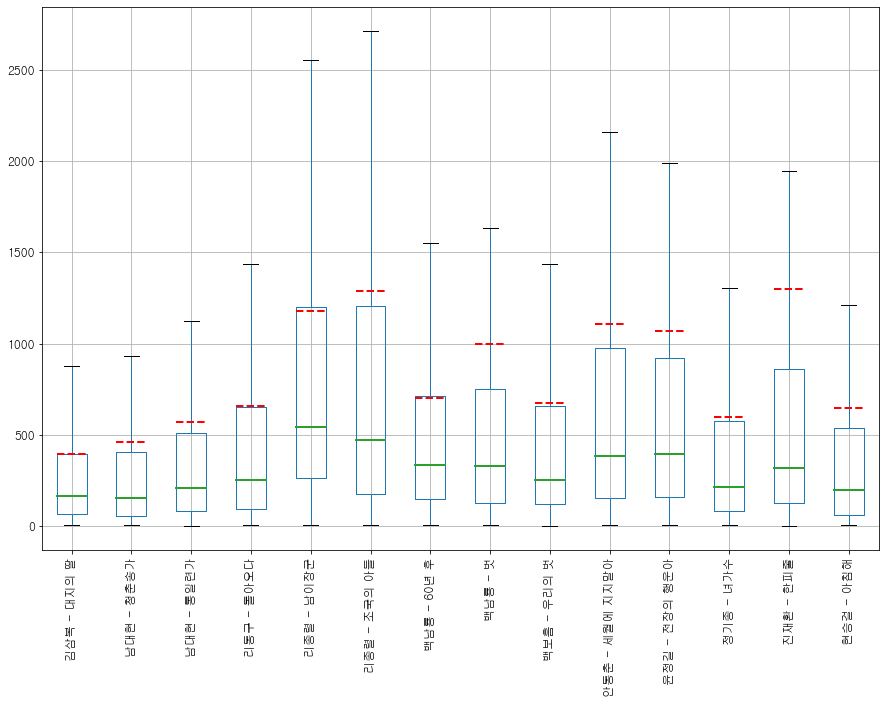

In [130]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\gulim.ttc').get_name(), size=12)
bp = famous_df.boxplot(figsize = (15, 10), showfliers=False, showmeans=True, meanline=True, return_type='dict', rot=90)
[item.set_linewidth(2) for item in bp['medians']]
[item.set_linewidth(2) for item in bp['means']]
[item.set_color('red') for item in bp['means']]
pass

In [391]:
df2.describe()

Korean Central News Agency       Poetry     Fiction
count                   500.00000    500.00000   500.00000
mean                    107.17284   2763.12852   695.53613
std                     429.92459  10193.23875  2702.78047
min                       1.38257      1.39690     1.41605
25%                       8.24915     63.01481    97.27057
50%                      23.81456    291.19931   241.60294
75%                      78.56058   1447.97320   677.68299
max                    8480.83891 155184.30224 56007.44665

## Regular writers

In [112]:
import kss
import os
import re

transl_table = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-（）１２３４５６７８９０《》≪≫＜＞〈〉．，－…∼",  u"'''\"\"--()1234567890\"\"\"\"\"\"\"\".,-.-")])

def preprocess_raw_content(full_content):
    full_content = full_content.translate(transl_table)
    full_content = re.sub(' +', ' ', full_content)
    full_content = full_content.replace('\xa0', '').replace('\xed', '').replace('􀃃', '')
    no_dialogue = [sentence for sentence in kss.split_sentences(full_content) if '"' not in sentence and '》' not in sentence and sentence.count(' ') > 3 and '. ' not in sentence]
    return no_dialogue
    
sample_data_path = './raw/novels'
sample_files = [file for file in os.listdir(sample_data_path) if file.endswith('.txt')]
novels_final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = preprocess_raw_content(''.join(fp.read().splitlines()))
    scores = []
    print(file)
    print(len(sentences))
    for i, sentence in enumerate(tqdm(random.sample(sentences, 500))):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    novels_final_results[file[:-4]] = scores
    

김광남 - 대계도.txt
2930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:52<00:00,  2.99it/s]


김금옥 - 고향의 노래.txt
2772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:21<00:00,  2.72it/s]


김대성 - 불타는 바다.txt
3005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:48<00:00,  2.29it/s]


김리돈 - 철의 신념.txt
2403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:55<00:00,  3.28it/s]


김문화 - 성토.txt
1198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:33<00:00,  2.82it/s]


김원종 - 우등불.txt
4021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:23<00:00,  2.18it/s]


김유권 - 래일에 사는 사람들.txt
2723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:30<00:00,  4.03it/s]


김응호 - 열풍.txt
3871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:49<00:00,  1.27s/it]


김정길 - 믿음.txt
3143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:38<00:00,  1.64it/s]


김청남 - 붉은 흙.txt
3617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:36<00:00,  2.65it/s]


리라순 - 은하수 흐른다.txt
3104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:40<00:00,  2.23it/s]


박찬은 - 불빛.txt
3645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:42<00:00,  1.62it/s]


석남진 - 너를 사랑하기에.txt
889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:24<00:00,  1.14it/s]


송병준 - 비수.txt
2586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:34<00:00,  1.91it/s]


온영수 - 작곡가 리면상.txt
3614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:09<00:00,  2.38it/s]


온영수 - 평양녀인.txt
3689


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:24<00:00,  2.18it/s]


정영종 - 북방의 노을.txt
3746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:51<00:00,  1.85it/s]


조상호 - 잠들지 않는 넋.txt
3573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:29<00:00,  2.03it/s]


한정아 - 녀학자의 고백.txt
2014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:57<00:00,  2.41it/s]


현명수 - 두견새는 잠들지 않는다.txt
3542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:57<00:00,  2.97it/s]


In [131]:
novels_df = pd.DataFrame(novels_final_results)
novels_df

김광남 - 대계도  김금옥 - 고향의 노래  김대성 - 불타는 바다  김리돈 - 철의 신념  김문화 - 성토  김원종 - 우등불  \
0        139.5         535.5         298.5        297.3     453.4      154.0   
1        133.5          93.8          69.0         32.4    6351.0       58.8   
2         77.0         280.3         867.0        153.4      15.2      270.8   
3        148.1        4887.0          78.6        213.6     717.5       52.0   
4        329.4         173.5          72.9         62.8    6809.0       60.6   
..         ...           ...           ...          ...       ...        ...   
495     1404.5          15.6         850.4         99.2    1135.2      335.2   
496       94.8         140.3         500.6        161.3      23.5      686.2   
497      108.2        1206.4         235.0         82.4     309.7      188.5   
498      797.5           9.8         135.4        303.0      25.7      277.9   
499      407.2          14.2         146.1       3239.4     200.4       65.0   

     김유권 - 래일에 사는 사람들  김응호 - 열풍  김정길 - 믿음  김청남 - 붉은 흙  리라순 - 은하수 흐른다  \
0               222.7    1609.6    1331.8       695.9          218.1   
1               141.4    1273.6     440.8       200.7          807.1   
2               395.8      80.8       6.3        10.9         2641.2   
3               201.1      48.7      83.2       236.9         1140.5   
4              2069.0      16.4       8.7     33535.9          157.1   
..                ...       ...       ...         ...            ...   
495              60.7     193.9      12.9      1543.4          501.5   
496            2115.9     724.3     157.5       249.2         2294.7   
497             285.2      62.9    1049.9      7204.8           94.3   
498              34.5    1566.1     237.8        11.9           49.3   
499             121.7     265.5     183.7        45.4           97.2   

     박찬은 - 불빛  석남진 - 너를 사랑하기에  송병준 - 비수  온영수 - 작곡가 리면상  온영수 - 평양녀인  \
0      3479.6           237.6     240.8          160.4      2109.9   
1        29.2             5.9     116.2         2193.4      1712.9   
2       636.2           181.1     989.8          164.2       244.4   
3        86.4          1042.9     132.0           55.0     19058.2   
4        93.1            39.8     297.0          115.2      1851.1   
..        ...             ...       ...            ...         ...   
495    1334.0           217.3    1000.2           73.5        87.6   
496      51.8           120.9      22.2          930.1        57.9   
497    1885.0           426.3     202.9         2776.9        42.2   
498     144.0            92.8     110.9         1089.9      6906.6   
499     142.0           536.0     169.9         2019.9       159.5   

     정영종 - 북방의 노을  조상호 - 잠들지 않는 넋  한정아 - 녀학자의 고백  현명수 - 두견새는 잠들지 않는다  
0           123.2           100.2           14.4              4798.0  
1          1649.2           582.7           23.1               213.2  
2           119.4           172.6           11.5               418.0  
3           199.5          1697.0          125.7               538.3  
4            14.5           915.2         1619.9              8410.4  
..            ...             ...            ...                 ...  
495        1057.5           220.8            2.7              1897.8  
496         963.2            22.8          177.4               967.8  
497        1156.3           573.3           18.8              1274.3  
498         625.8           156.5          155.1              1026.6  
499          82.2            83.5          165.3              1060.5  

[500 rows x 20 columns]

In [134]:
novels_df.describe()

김광남 - 대계도  김금옥 - 고향의 노래  김대성 - 불타는 바다  김리돈 - 철의 신념  김문화 - 성토  \
count      500.0         500.0         500.0        500.0     500.0   
mean       529.2         464.6         976.7       1517.3     924.6   
std        917.6        1020.1        2375.7      22924.9    2220.8   
min          3.3           4.0           2.8          3.3       3.0   
25%         96.8          66.8         154.2         73.0     114.5   
50%        234.0         158.8         365.7        182.5     304.5   
75%        575.0         448.2         973.6        502.4     766.7   
max      10165.5       12200.1       41333.7     512480.8   30565.2   

       김원종 - 우등불  김유권 - 래일에 사는 사람들  김응호 - 열풍  김정길 - 믿음  김청남 - 붉은 흙  \
count      500.0             500.0     500.0     500.0       500.0   
mean       592.8             671.8     604.3     564.4       736.1   
std       2496.9            1136.1    1203.4    1162.6      1870.5   
min          2.6               1.8       5.8       6.3         3.7   
25%         89.8             129.0     109.2     102.0       119.8   
50%        211.3             291.7     276.9     269.4       327.0   
75%        504.3             676.5     634.2     591.8       699.6   
max      52411.4            8896.3   17183.1   14358.2     33535.9   

       리라순 - 은하수 흐른다  박찬은 - 불빛  석남진 - 너를 사랑하기에  송병준 - 비수  온영수 - 작곡가 리면상  \
count          500.0     500.0           500.0     500.0          500.0   
mean           391.3     728.6           325.5     634.4          638.8   
std            903.7    2610.5           654.7    1233.4         1364.4   
min              1.3       2.2             3.5       5.6            3.1   
25%             54.9     112.2            51.6      70.9           91.5   
50%            147.2     276.0           131.4     200.5          233.4   
75%            385.9     656.1           313.8     643.7          610.5   
max          12952.8   49441.8          8107.5   12256.0        16090.6   

       온영수 - 평양녀인  정영종 - 북방의 노을  조상호 - 잠들지 않는 넋  한정아 - 녀학자의 고백  \
count       500.0         500.0           500.0          500.0   
mean        743.0         685.9           563.4          501.3   
std        1305.2        1543.5           961.8         2235.6   
min           2.1           4.9             3.4            2.7   
25%         141.5         143.5            82.9           67.2   
50%         356.3         344.7           218.9          154.8   
75%         803.8         730.6           610.8          380.0   
max       19058.2       24084.6          9013.2        44957.3   

       현명수 - 두견새는 잠들지 않는다  
count               500.0  
mean                902.0  
std                3890.3  
min                   1.3  
25%                 121.9  
50%                 318.5  
75%                 722.8  
max               63029.2

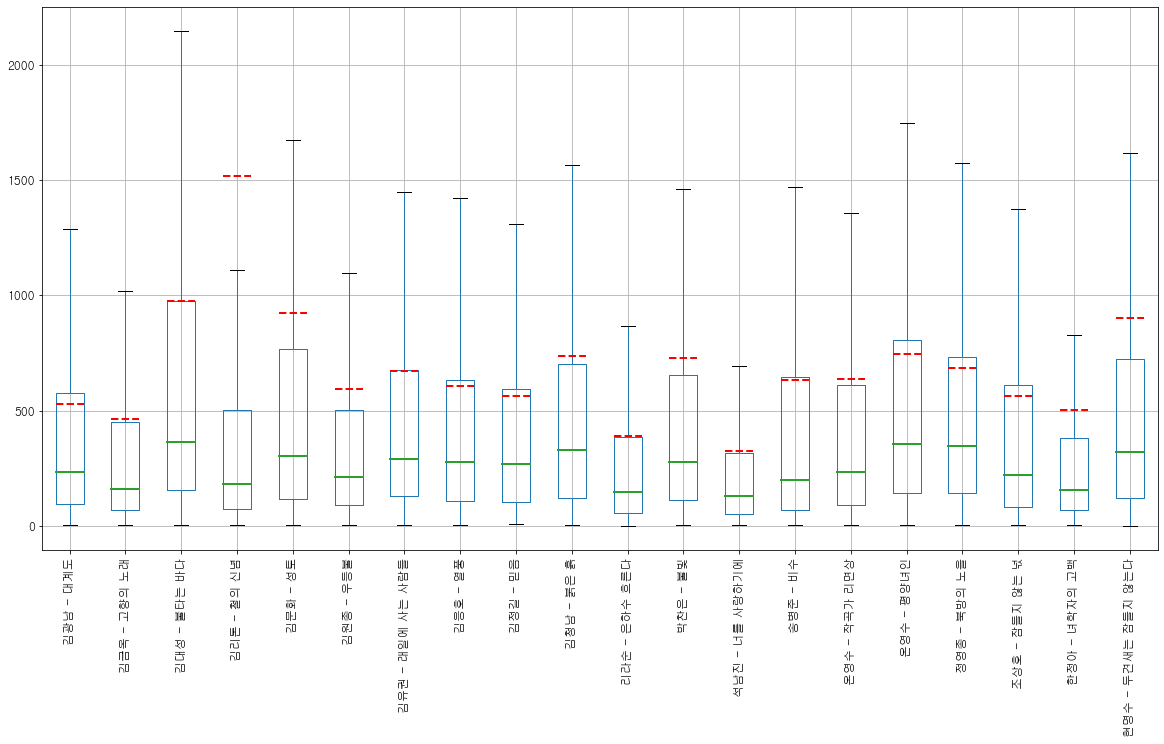

In [136]:
bp = novels_df.boxplot(figsize = (20, 10), showfliers=False, showmeans=True, meanline=True, return_type='dict', rot=90)
[item.set_linewidth(2) for item in bp['medians']]
[item.set_linewidth(2) for item in bp['means']]
[item.set_color('red') for item in bp['means']]
pass

## Immortal writers

In [137]:
import kss
import os
import re

transl_table = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-（）１２３４５６７８９０《》≪≫＜＞〈〉．，－…∼",  u"'''\"\"--()1234567890\"\"\"\"\"\"\"\".,-.-")])

def preprocess_raw_content(full_content):
    full_content = full_content.translate(transl_table)
    full_content = re.sub(' +', ' ', full_content)
    full_content = full_content.replace('\xa0', '').replace('\xed', '').replace('􀃃', '')
    no_dialogue = [sentence for sentence in kss.split_sentences(full_content) if '"' not in sentence and '》' not in sentence and sentence.count(' ') > 3 and '. ' not in sentence]
    return no_dialogue
    
sample_data_path = './raw/pulmyol'
sample_files = [file for file in os.listdir(sample_data_path) if file.endswith('.txt')]
pulmyol_final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = preprocess_raw_content(''.join(fp.read().splitlines()))
    scores = []
    print(file)
    print(len(sentences))
    for i, sentence in enumerate(tqdm(random.sample(sentences, 500))):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    pulmyol_final_results[file[:-4]] = scores
    

권정웅 - 빛나는 아침.txt
2784



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:03<04:15,  1.66it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:48<03:17,  1.75it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:31<02:33,  1.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:16<02:02,  1.54it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:12<01:09,  1.57it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [04:57<00:14,  2.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:19<00:00,  1.78it/s]

권정웅 - 푸른하늘.txt
3162



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:49<03:55,  1.79it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:30<02:48,  2.04it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:19<03:20,  1.33it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:15<03:09,  1.01s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [04:10<01:15,  1.45it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [05:10<00:15,  2.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:30<00:00,  1.93it/s]

김삼복 - 청산벌.txt
2436



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:53<06:08,  1.15it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:47<03:43,  1.54it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:54<04:47,  1.08s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:03<01:45,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:55<01:23,  1.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [05:42<00:16,  1.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:07<00:00,  1.02it/s]

김수경 - 삼천리강산.txt
2502



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:15<04:21,  1.62it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:17<02:18,  2.48it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:26<02:23,  1.86it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:27<01:54,  1.65it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:41<01:30,  1.23it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:45<00:25,  1.32it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:10<00:00,  2.06it/s]

리동구 - 비약의 나래.txt
4434



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:45<03:43,  1.89it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:26<04:05,  1.41it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:10<02:25,  1.82it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [02:56<01:33,  2.01it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [03:40<00:47,  2.32it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [04:25<00:22,  1.40it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:39<00:00,  2.08it/s]

리동구 - 영원한 력사.txt
3757



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:34<02:55,  2.41it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:20<03:39,  1.57it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:05<02:33,  1.73it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [02:44<01:16,  2.47it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [03:27<02:39,  1.45s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [04:18<00:22,  1.41it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:31<00:00,  3.03it/s]

리령철 - 아리랑.txt
2579



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:07<11:56,  1.69s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:15<04:11,  1.37it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:09<02:31,  1.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:16<02:37,  1.20it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [05:31<00:56,  1.91it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [06:53<00:09,  3.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:39<00:00,  2.05s/it]

리신현 - 전환의 년대.txt
1140



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:58<04:40,  1.51it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:55<06:09,  1.07s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:54<02:38,  1.69it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:04<02:54,  1.08it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:56<01:15,  1.48it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:08<00:17,  1.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:29<00:00,  1.59it/s]

리종렬 - 예지.txt
3265



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:05<08:13,  1.17s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:06<03:45,  1.53it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:23<04:07,  1.08it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:28<02:53,  1.09it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [05:41<01:11,  1.54it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [06:54<00:45,  1.43s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:27<00:00,  1.15s/it]

림봉철 - 아침은 빛나라.txt
3641



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:10<10:21,  1.47s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:15<04:32,  1.27it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:19<04:57,  1.11s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:25<03:12,  1.02s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:23<01:13,  1.50it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:33<00:26,  1.23it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:01<00:00,  1.81it/s]

박룡운 - 번영의 길.txt
3909



 16%|██████████████████████████▌                                                                                                                                             | 79/500 [01:07<03:41,  1.90it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [02:16<03:18,  1.73it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [03:24<04:03,  1.09it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [04:34<02:05,  1.49it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [05:34<01:29,  1.21it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [06:51<01:16,  2.47s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:15<00:00,  1.35it/s]

박태수 - 존엄.txt
2361



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:23<06:43,  1.05it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:32<04:30,  1.27it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:46<03:39,  1.22it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [05:24<02:42,  1.16it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [06:51<01:39,  1.11it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [08:30<00:36,  1.09s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:04<00:00,  1.33s/it]

백남룡 - 계승자.txt
2727



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:13<07:34,  1.07s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:24<06:15,  1.09s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:38<03:17,  1.36it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:41<02:43,  1.16it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:43<01:27,  1.27it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:56<00:20,  1.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:31<00:00,  1.19s/it]

백남룡 - 동해천리.txt
3015



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:07<07:35,  1.08s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:09<05:54,  1.03s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:12<02:41,  1.65it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:28<02:32,  1.24it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:43<01:45,  1.05it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:55<00:40,  1.24s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:24<00:00,  1.02it/s]

백남룡 - 봄의 서곡.txt
1438



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:56<04:17,  1.64it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:59<03:12,  1.79it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:03<02:59,  1.48it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [03:59<02:31,  1.25it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [05:01<02:18,  1.26s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [06:02<00:25,  1.27it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:27<00:00,  1.57it/s]

백남룡 - 야전렬차.txt
2145



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:33<12:27,  1.77s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [03:11<06:47,  1.18s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [05:00<04:31,  1.02s/it]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [06:50<03:47,  1.21s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [08:23<01:57,  1.07s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [10:16<00:40,  1.27s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:57<00:00,  1.10s/it]

백보흠, 송상원 - 영생.txt
2528



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:58<05:49,  1.21it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:56<04:13,  1.35it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [03:00<02:11,  2.02it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:58<01:48,  1.72it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:54<01:15,  1.45it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [05:55<00:32,  1.05s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:22<00:00,  1.09s/it]

송상원 - 대박산마루.txt
1689



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:51<03:54,  1.80it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:55<06:06,  1.06s/it]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:41<03:12,  1.38it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:45<02:05,  1.50it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:42<00:55,  1.98it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [05:54<00:19,  1.60it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:15<00:00,  1.33it/s]

송상원 - 총검을 들고.txt
3501



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:58<03:11,  2.20it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:52<04:52,  1.18it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:40<02:26,  1.82it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:28<01:37,  1.92it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [04:23<00:59,  1.86it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [05:31<00:27,  1.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:48<00:00,  1.45it/s]

안동춘 - 평양의 봉화.txt
3158



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:58<05:08,  1.37it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:00<02:53,  1.99it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:54<04:54,  1.10s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [03:53<02:27,  1.28it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:51<01:02,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [05:44<00:25,  1.27it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:12<00:00,  1.41s/it]

안동춘 - 푸른 산악.txt
2466



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:57<07:14,  1.03s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:53<03:05,  1.86it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:57<05:57,  1.34s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:00<03:38,  1.16s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:57<01:00,  1.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [05:52<00:18,  1.67it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:17<00:00,  1.60it/s]

윤경찬 - 새 나라.txt
3058



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:49<05:18,  1.33it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:54<04:29,  1.28it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:58<03:27,  1.28it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:50<02:24,  1.31it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [04:51<01:07,  1.64it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [05:48<00:23,  1.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:14<00:00,  1.07s/it]

윤정길 - 의리의 전역.txt
4382



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:50<03:10,  2.22it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:50<04:18,  1.34it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:48<03:08,  1.42it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [03:50<03:12,  1.02s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:44<01:17,  1.43it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [05:46<00:21,  1.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:04<00:00,  1.82it/s]

전흥식 - 해방전야.txt
3248



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:46<05:15,  1.34it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:31<02:23,  2.41it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:18<03:40,  1.21it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [03:15<01:43,  1.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:05<01:49,  1.01it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [05:07<00:27,  1.19it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:36<00:00,  1.80it/s]

정기종 - 력사의 대하.txt
1713



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:59<03:57,  1.78it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:48<03:06,  1.85it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:42<02:03,  2.15it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:37<01:24,  2.21it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:26<00:55,  1.95it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [05:24<00:14,  2.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:49<00:00,  1.09it/s]

정기종 - 별의 세계.txt
2725



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:53<03:50,  1.83it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:38<02:48,  2.05it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:33<02:48,  1.59it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:32<02:20,  1.33it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:13<01:21,  1.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [04:54<00:16,  1.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:17<00:00,  1.58it/s]

정기종 - 불.txt
2435



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:53<05:54,  1.19it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:37<02:20,  2.45it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:36<01:34,  2.81it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:21<01:27,  2.13it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [04:14<00:43,  2.48it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [05:11<00:26,  1.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:27<00:00,  1.40it/s]

정기종 - 운명.txt
848



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:44<03:02,  2.32it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [01:25<03:51,  1.47it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                       | 239/500 [02:17<01:29,  2.93it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 318/500 [03:01<01:00,  3.01it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 397/500 [03:52<01:51,  1.09s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 476/500 [04:39<00:14,  1.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:50<00:00,  2.31it/s]

정기종 - 조선의 힘.txt
6162



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:42<07:35,  1.08s/it]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:41<03:26,  1.67it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [02:29<02:46,  1.59it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:17<01:58,  1.58it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [04:05<01:00,  1.81it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [04:48<00:18,  1.70it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:05<00:00,  1.19it/s]

진재환 - 잊지 못할 겨울.txt
5792



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:06<05:56,  1.19it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:09<04:10,  1.38it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:13<02:48,  1.59it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:14<01:08,  2.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:20<01:47,  1.03it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [06:19<00:16,  2.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:59<00:00,  1.11it/s]

천세봉 - 은하수.txt
3175



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:50<03:43,  1.89it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:41<03:10,  1.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:22<02:48,  1.57it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [03:16<01:30,  2.08it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [04:06<02:11,  1.19s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [05:00<00:18,  1.70it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:22<00:00,  1.12s/it]

천세봉 - 조선의 봄.txt
2962



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:04<05:53,  1.20it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [01:57<04:18,  1.33it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [02:52<01:42,  2.61it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [03:45<02:14,  1.41it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [04:35<01:10,  1.57it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [05:36<00:25,  1.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:58<00:00,  1.25it/s]

천세봉 - 혁명의 여명.txt
2666



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:45<03:57,  1.78it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [01:33<01:58,  2.89it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [02:20<02:27,  1.80it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [03:09<01:37,  1.92it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [03:54<00:38,  2.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [04:40<00:12,  2.37it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:58<00:00,  1.97it/s]

최영조 - 미래.txt
3265



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [00:52<04:15,  1.66it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:02<03:13,  1.79it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [03:39<07:49,  1.76s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 311/500 [04:40<01:45,  1.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 389/500 [05:59<01:16,  1.45it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [07:18<00:18,  1.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:43<00:00,  1.12s/it]

최창학 - 위대한 사랑.txt
4416



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:10<05:51,  1.21it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:14<05:17,  1.09it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [03:38<03:12,  1.38it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [04:44<01:50,  1.70it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [05:53<01:48,  1.01it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [06:57<00:23,  1.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:18<00:00,  1.64it/s]

탁숙본 - 명맥.txt
2751



 16%|██████████████████████████▏                                                                                                                                             | 78/500 [01:17<07:40,  1.09s/it]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [02:28<05:03,  1.13it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [03:31<02:07,  2.07it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [04:22<02:16,  1.37it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [05:30<01:47,  1.02it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [06:37<00:38,  1.25s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:06<00:00,  1.20it/s]

허춘식 - 천지.txt
2836



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:42<14:12,  2.02s/it]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:59<06:47,  1.18s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 233/500 [04:31<03:46,  1.18it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [05:57<04:07,  1.32s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [07:22<01:26,  1.26it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [08:37<00:28,  1.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:13<00:00,  1.66s/it]

현승걸 - 백두산 기슭.txt
3589



 15%|█████████████████████████▊                                                                                                                                              | 77/500 [01:04<03:45,  1.88it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 155/500 [02:27<04:32,  1.27it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [03:45<03:20,  1.33it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [05:01<03:18,  1.06s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [06:09<00:55,  1.96it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [07:21<00:20,  1.56it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:52<00:00,  1.07it/s]

In [138]:
pulmyol_df = pd.DataFrame(pulmyol_final_results)
pulmyol_df

권정웅 - 빛나는 아침  권정웅 - 푸른하늘  김삼복 - 청산벌  김수경 - 삼천리강산  리동구 - 비약의 나래  \
0           298.9       163.3      182.4         26.0          31.9   
1            62.7       628.6       30.3         44.4          54.3   
2          1045.8        74.5      547.4        549.7         103.9   
3            55.6      1533.0      479.6       2256.4          16.3   
4          1162.7       109.4       78.9         21.5        3244.0   
..            ...         ...        ...          ...           ...   
495         406.4       119.3      207.6        213.8          97.6   
496        2088.5        14.0      126.6         71.7          94.0   
497          20.7       115.1       78.6       1315.4          80.3   
498        3890.2       213.6       25.6        321.7         113.8   
499        3410.4       475.2       12.2         94.0         497.1   

     리동구 - 영원한 력사  리령철 - 아리랑  리신현 - 전환의 년대  리종렬 - 예지  림봉철 - 아침은 빛나라  ...  \
0          1145.8       59.9          23.6     125.5          509.2  ...   
1           100.7      214.7         461.9     429.4          105.7  ...   
2           110.8      117.3         618.9      90.8         1118.1  ...   
3             5.5      318.6         430.8     107.8          169.4  ...   
4           794.7      436.8         250.8     646.4          931.1  ...   
..            ...        ...           ...       ...            ...  ...   
495         614.6       78.9          28.5     580.3         2300.6  ...   
496          43.5      855.6         759.4      16.6           35.2  ...   
497         845.0      161.5          33.2      72.9            3.1  ...   
498          15.2      155.0         168.0      92.0          249.7  ...   
499         196.8       11.6          56.6     827.6          201.3  ...   

     정기종 - 조선의 힘  진재환 - 잊지 못할 겨울  천세봉 - 은하수  천세봉 - 조선의 봄  천세봉 - 혁명의 여명  \
0          537.4           112.1      757.2       1163.1         103.5   
1           77.1           158.3     5653.4        152.4         238.3   
2            4.3           581.3       68.8        435.4         468.5   
3          119.9           151.6      446.5        442.2         571.0   
4          160.4           741.2      586.7        865.5        3174.1   
..           ...             ...        ...          ...           ...   
495          1.3           264.0      144.1         55.3        1109.5   
496        158.0           331.4     1395.7        241.1         340.2   
497        643.3          1048.0      544.4       1179.0         120.8   
498        163.2           209.2       92.2        924.3         107.3   
499        321.8           572.1       37.3        366.1         471.5   

     최영조 - 미래  최창학 - 위대한 사랑  탁숙본 - 명맥  허춘식 - 천지  현승걸 - 백두산 기슭  
0       150.7         443.5      56.2     147.9         144.0  
1       196.6         515.2      54.6     619.3         184.9  
2        59.3          52.9      87.8     257.4        1892.7  
3        50.4        1526.0      86.0     296.7          20.8  
4        82.8        1047.6     457.9    1112.2         148.0  
..        ...           ...       ...       ...           ...  
495    1559.7         136.9    1505.3     377.7        2032.4  
496     826.7         175.0     419.1     768.8         159.5  
497     713.4         754.6       2.6     815.9         133.4  
498      99.1          23.4    1349.6     132.4         564.4  
499      36.7         152.7     281.4      17.6          47.2  

[500 rows x 38 columns]

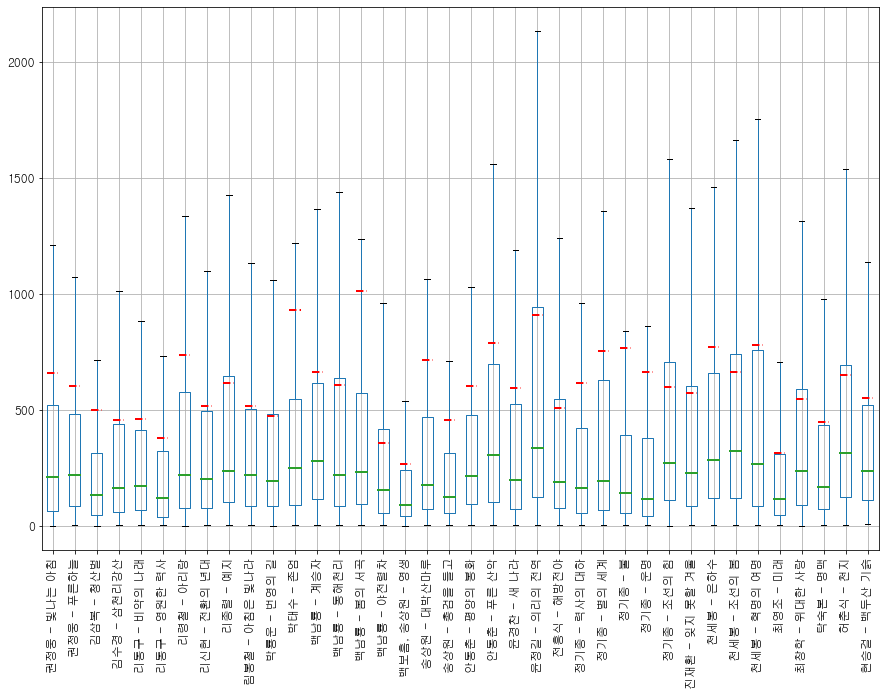

In [140]:
bp = pulmyol_df.boxplot(figsize = (15, 10), showfliers=False, showmeans=True, meanline=True, return_type='dict', rot=90)
[item.set_linewidth(2) for item in bp['medians']]
[item.set_linewidth(2) for item in bp['means']]
[item.set_color('red') for item in bp['means']]
pass

In [1]:
bp = pulmyol_df.boxplot(figsize = (15, 10), showfliers=False, showmeans=True, meanline=True, return_type='dict', rot=90)
[item.set_linewidth(2) for item in bp['medians']]
[item.set_linewidth(2) for item in bp['means']]
[item.set_color('red') for item in bp['means']]
pass

NameError: name 'pulmyol_df' is not defined